## This exercise performs hands-on regression on COVID-19 data for Chicago to predict the number of infections
This is an adapted version from source: https://towardsdatascience.com/understanding-regression-using-covid-19-dataset-detailed-analysis-be7e319e3a50


In [4]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Read the Data
data = pd.read_csv('https://raw.githubusercontent.com/Ayushijain09/Regression-on-COVID-dataset/master/COVID-19_Daily_Testing.csv')

In [6]:
# Display the data
print(data.shape)
data.head()

(89, 59)


,Date,Day,Tests,Cases,People Not-Positive - Total,People Tested - Age 0-17,People Tested - Age 18-29,People Tested - Age 30-39,People Tested - Age 40-49,People Tested - Age 50-59,People Tested - Age 60-69,People Tested - Age 70-79,People Tested - Age 80+,People Tested - Age Unknown,People Tested - Female,People Tested - Male,People Tested - Gender Unknown,People Tested - Latinx,People Tested - Asian Non-Latinx,People Tested - Black Non-Latinx,People Tested - White Non-Latinx,People Tested - Other Race Non-Latinx,People Tested - Unknown Race/Ethnicity,People Positive - Age 0-17,People Positive - Age 18-29,People Positive - Age 30-30,People Positive - Age 40-49,People Positive - Age 50-59,People Positive - Age 60-69,People Positive - Age 70-79,People Positive - Age 80+,People Positive - Age Unknown,People Positive - Female,People Positive - Male,People Positive - Gender Unknown,People Positive - Latinx,People Positive - Asian Non-Latinx,People Positive - Black Non-Latinx,People Positive - White Non-Latinx,People Positive - Other Race Non-Latinx,People Positive - Unknown Race/Ethnicity,People Not-Positive - Age 0-17,People Not-Positive - Age 18-29,People Not-Positive - Age 30-39,People Not-Positive - Age 40-49,People Not-Positive - Age 50-59,People Not-Positive - Age 60-69,People Not-Positive - Age 70-79,People Not-Positive - Age 80+,People Not-Positive - Age Unknown,People Not-Positive - Female,People Not-Positive - Male,People Not-Positive - Gender Unknown,People Not-Positive - Latinx,People Not-Positive - Asian Non-Latinx,People Not-Positive - Black Non-Latinx,People Not-Positive - White Non-Latinx,People Not-Positive - Other Race Non-Latinx,People Not-Positive - Unknown Race/Ethnicity
0,03-01-20,Sunday,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,05-02-20,Saturday,"2,431",705,"1,726",129,470,458,458,412,281,128,94,1,"1,238","1,158",35,569,39,376,276,73,"1,098",24,141,120,152,137,76,39,16,0,340,361,4,343,9,103,51,22,177,105,329,338,306,275,205,89,78,1,898,797,31,226,30,273,225,51,921
2,05/14/2020,Thursday,"4,098",772,"3,326",260,805,833,685,604,471,253,171,16,"2,049","1,786",263,848,55,581,510,144,"1,960",48,167,153,131,107,95,42,29,0,395,362,15,319,12,151,68,35,187,212,638,680,554,497,376,211,142,16,"1,654","1,424",248,529,43,430,442,109,"1,773"
3,03-05-20,Thursday,17,1,16,4,2,0,4,3,2,0,2,0,8,9,0,2,0,5,2,1,7,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,4,2,0,4,2,2,0,2,0,7,9,0,2,0,4,2,1,7
4,03-06-20,Friday,18,3,15,1,5,1,3,3,2,2,0,1,8,10,0,2,0,1,5,1,9,0,0,0,2,0,1,0,0,0,0,3,0,0,0,0,3,0,0,1,5,1,1,3,1,2,0,1,8,7,0,2,0,1,2,1,9


The presence of commas in some of the numeric columns above (all columns from 2 on, using Python's indexing convention) suggests that some of them are represented as strings rather than integers. Let's check if that's true. 

In [7]:
column_contains_strings = data.iloc[:,2:].applymap(type).eq(str).any()
column_contains_strings

Tests                                            True
Cases                                            True
People Not-Positive - Total                      True
People Tested - Age 0-17                        False
People Tested - Age 18-29                        True
People Tested - Age 30-39                        True
People Tested - Age 40-49                       False
People Tested - Age 50-59                       False
People Tested - Age 60-69                       False
People Tested - Age 70-79                       False
People Tested - Age 80+                         False
People Tested - Age Unknown                     False
People Tested - Female                           True
People Tested - Male                             True
People Tested - Gender Unknown                  False
People Tested - Latinx                           True
People Tested - Asian Non-Latinx                False
People Tested - Black Non-Latinx                False
People Tested - White Non-La

# Exercise: Data Cleaning

Ideally, every value in the Pandas `Series` above should be `False` (the column names are `Series` indices rather than values). We'll have to convert the values of the columns from 2 on to integers if they're currently represented as strings. First, we'll have to eliminate the commas in the ostensibly numeric columns. You might find the following methods useful: [pd.Series.str.replace()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html), [pd.to_numeric()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html), 

In [8]:
### BEGIN CODE HERE ###
# Iterate over the columns in data
for i in range(data.shape[1]):
  # Carry out the replacement and conversion if i is at least 2 and the column contains strings
  # Don't forget that column_contains_strings ignores the 0th and 1st columns of data 
  if (i >= 2) & (column_contains_strings[i-2]==True):
    # Eliminate any commas in the number strings
    data.iloc[:,i]=data.iloc[:,i].str.replace(',', '')
    # Convert the string column to a numeric column
    data.iloc[:,i]=pd.to_numeric(data.iloc[:,i])
### END CODE HERE ###

Verify that only the `Date` and `Day` columns contain strings now

In [9]:
data.applymap(type).eq(str).any()

Date                                             True
Day                                              True
Tests                                           False
Cases                                           False
People Not-Positive - Total                     False
People Tested - Age 0-17                        False
People Tested - Age 18-29                       False
People Tested - Age 30-39                       False
People Tested - Age 40-49                       False
People Tested - Age 50-59                       False
People Tested - Age 60-69                       False
People Tested - Age 70-79                       False
People Tested - Age 80+                         False
People Tested - Age Unknown                     False
People Tested - Female                          False
People Tested - Male                            False
People Tested - Gender Unknown                  False
People Tested - Latinx                          False
People Tested - Asian Non-La

### Extract the first 10 numeric columns. Inspect visually how those features correlate with each other, print out some summary statistics, and display the first few rows of the reduced numeric dataset. 

<Figure size 1440x720 with 0 Axes>

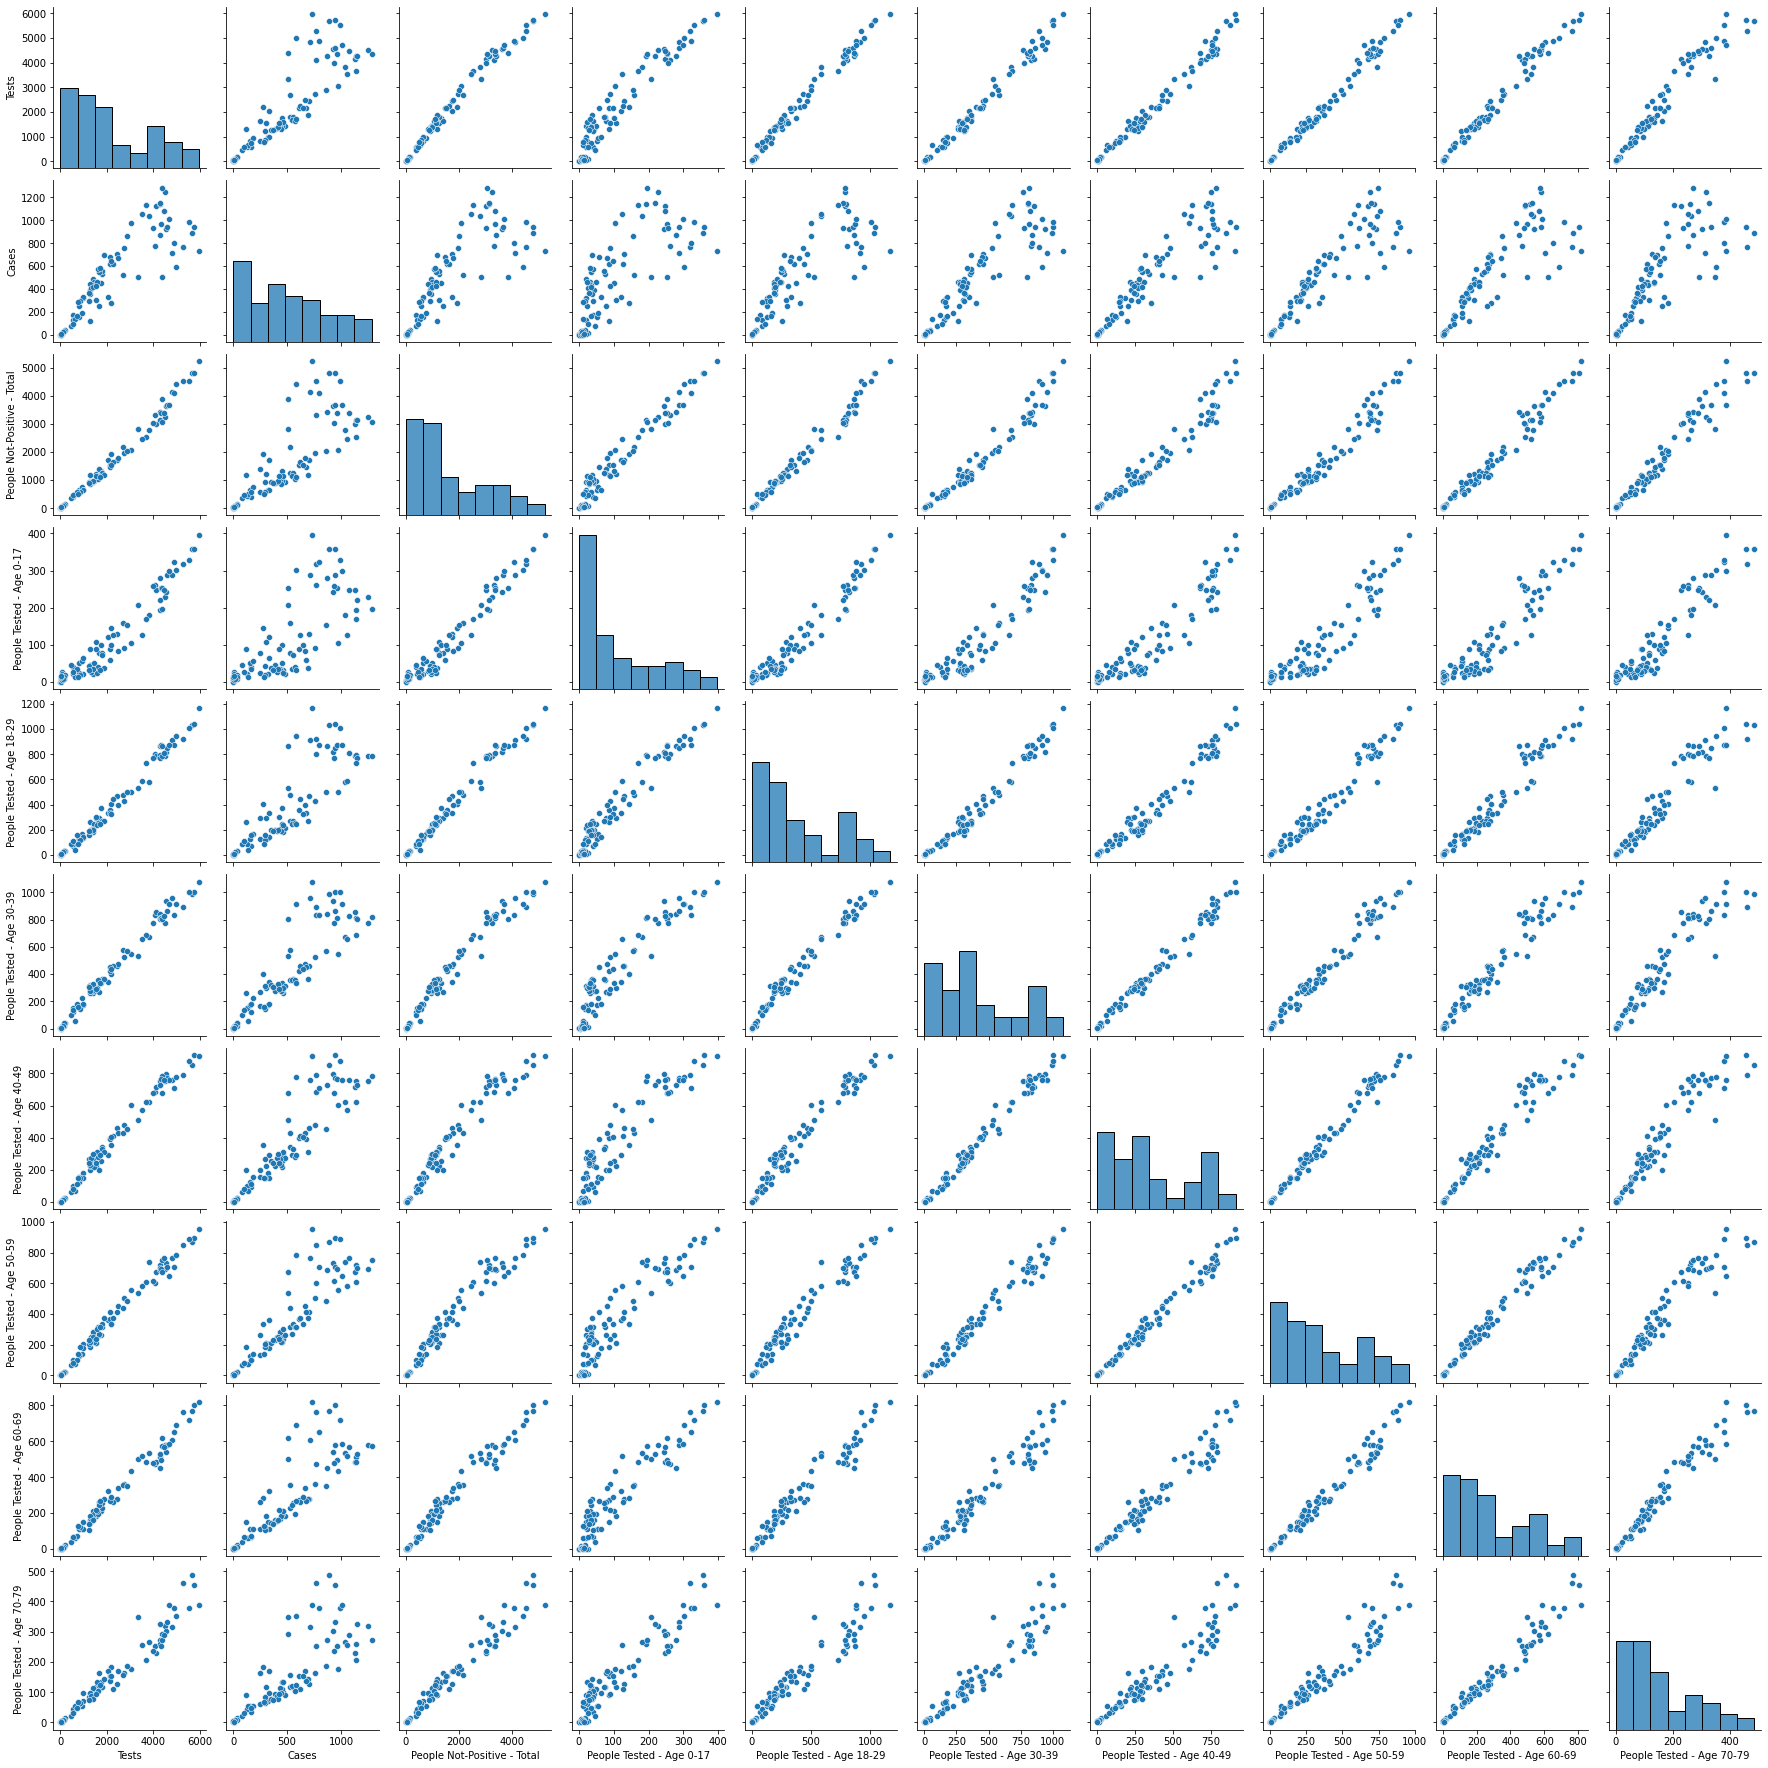

In [ ]:
# Plot pairwise dependence of features, select columns 2-12 only for example
data_numeric = data.iloc[:,2:12]
plt.figure(figsize=(20, 10))
sns.pairplot(data_numeric)
plt.show()

In [ ]:
print(data_numeric.shape)
data_numeric.describe()

(89, 10)


,Tests,Cases,People Not-Positive - Total,People Tested - Age 0-17,People Tested - Age 18-29,People Tested - Age 30-39,People Tested - Age 40-49,People Tested - Age 50-59,People Tested - Age 60-69,People Tested - Age 70-79
count,89.00000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,2165.47191,499.955056,1665.516854,111.011236,381.707865,414.348315,361.584270,355.247191,280.719101,151.112360
std,1735.84995,365.764266,1423.982477,109.086652,328.557564,317.050079,281.190925,275.699288,229.431114,125.698995
min,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,801.00000,169.000000,572.000000,25.000000,129.000000,167.000000,147.000000,136.000000,112.000000,55.000000
50%,1645.00000,460.000000,1175.000000,63.000000,267.000000,332.000000,294.000000,283.000000,216.000000,118.000000
75%,3818.00000,768.000000,2827.000000,194.000000,728.000000,686.000000,624.000000,607.000000,484.000000,253.000000
max,5971.00000,1285.000000,5237.000000,397.000000,1167.000000,1080.000000,914.000000,957.000000,819.000000,486.000000


In [ ]:
data_numeric.head()

,Tests,Cases,People Not-Positive - Total,People Tested - Age 0-17,People Tested - Age 18-29,People Tested - Age 30-39,People Tested - Age 40-49,People Tested - Age 50-59,People Tested - Age 60-69,People Tested - Age 70-79
0,1,0,1,0,0,1,0,0,0,0
1,2431,705,1726,129,470,458,458,412,281,128
2,4098,772,3326,260,805,833,685,604,471,253
3,17,1,16,4,2,0,4,3,2,0
4,18,3,15,1,5,1,3,3,2,2


### Variance Inflation Factor (VIF)

The pair plots above suggest that many of the features above correlate strongly with each other. Such multi-linearity can cause problems with model convergence. In your next exercise, you will identify which features are most responsible for these issues. To do so, you will calculate the variance inflation factor (VIF) for each feature. If a feature has VIF>10, it has high multi-linearity.

A feature $X_j$ in an array of features $X$ has a VIF given by 

$$\textrm{VIF}_j = \frac{1}{1 - R^2_j}.$$

In turn, the coefficient of determination $R^2_i$ for the $j$th feature of $X$ is given by 

$$R^2_j = 1 - \frac{\sum_i (X_{ij} - \hat{X}_{ij})^2}{\sum_i (X_{ij} - \overline{X}_{j})^2}.$$

In the formula above, $i$ is the row index of $X$, $j$ is the column index, $\hat{X}_{ij}$ is the predicted value of $X_{ij}$ obtained by performing linear regression with $X_j$ as the target column and all of the other columns of $X$ as features, and $\overline{X}_{j})$ is the mean value of all elements in $X_j$. 

First, we need a function for computing VIF

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Calculate VIF for a single column

In the following cell, you see how to pass a single column of numeric data into the `variance_inflation_factors()` function to determine its colinearity. By definition, a given feature is perfectly colinear with itself, with a VIF of 1. 

In [ ]:
variance_inflation_factors(data_numeric.iloc[:,0])

const    2.57394
Tests    1.00000
Name: VIF, dtype: float64

In case you had forgotten from the summary statistics above, the 0th column of the `data_numeric` `DataFrame` is named `'Tests'`, which the `Series` output by the most recent call to `variance_inflation_factors()` reflects. Notice also the VIF score for the `const` column which we added locally, within the scope of `variance_inflation_factors()`. For our purposes, we can ignore it. 

### Exercise: Use VIF to detect highly colinear features

First, pass the entire reduced numeric dataset into the VIF function

In [ ]:
### BEGIN CODE HERE ###
variance_inflation_factors(data_numeric)
### END CODE HERE ###

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


const                            3.575608
Tests                                 inf
Cases                                 inf
People Not-Positive - Total           inf
People Tested - Age 0-17        61.174508
People Tested - Age 18-29      254.708643
People Tested - Age 30-39      169.788226
People Tested - Age 40-49      202.540120
People Tested - Age 50-59      184.447227
People Tested - Age 60-69      161.858876
People Tested - Age 70-79       63.594813
Name: VIF, dtype: float64

If you saw any infinite values above, don't panic just yet. Call the VIF function again, but this time, don't pass in the columns with finite VIF values above 10.

In [ ]:
### BEGIN CODE HERE ###
variance_inflation_factors(data_numeric[['Tests', 'Cases', 'People Not-Positive - Total']])
### END CODE HERE ###

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


const                          2.89786
Tests                              inf
Cases                              inf
People Not-Positive - Total        inf
Name: VIF, dtype: float64

Did you still get several infinite VIF values? That seems a bit disconcerting. Just in case, try passing the first 2 columns from the subset above into the VIF function.

In [ ]:
### BEGIN CODE HERE ###
variance_inflation_factors(data_numeric[['Tests', 'Cases']])
### END CODE HERE ###

const    2.897860
Tests    4.481884
Cases    4.481884
Name: VIF, dtype: float64

Aha! This should yield a VIF well below 10.

### Exercise: Extract the feature and target from the dataset

By now, we're down to 2 numeric columns from the original dataset. The goal is to predict the number of COVID-19 cases, so one column is a feature, and the other is your target. Extract them from the dataset as NumPy arrays. Make sure that each array is 2D, and that its rows correspond to training examples.

In [ ]:
### BEGIN CODE HERE ###
# Feature
X = data_numeric['Tests'].values.reshape(-1,1)
# Target
y = data_numeric['Cases'].values.reshape(-1,1)
### END CODE HERE

### Exercise: Linear Regression

Apply linear regression to the feature and target. You might find scikit-learn's [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression) class and its methods helpful. 

The linear model is: Y = 97.777 + 0.18572X


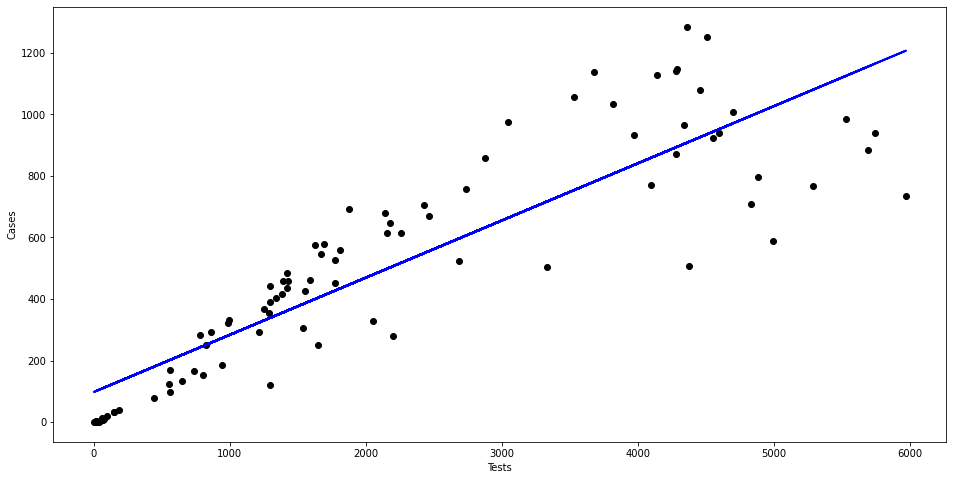

In [ ]:
### START CODE HERE ###
# Instantiate the linear regression model
reg = LinearRegression() 
# Train the model on the full feature and target arrays
# Keep in mind that this is not good practice as a general rule
# We're doing so for illustrative purposes only
reg.fit(X, y) 
# Use your newly trained model to compute predicted target values based on the feature values
predictions = reg.predict(X)
### END CODE HERE ###
# Visualize your (highly reduced) ground truth data and model
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
plt.figure(figsize=(16, 8))
plt.scatter(
    X,
    y,
    c='black'
)
plt.plot(
    X,
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("Tests")
plt.ylabel("Cases")
plt.show()

### Exercise: Polynomial Regression

A number of points in the plot above appear to be quite far off of the predicted line. Let's see if fitting a polynomial to our data produces better results. Polynomial regression isn't very different from linear regression; the prediction function is still linear in the $\theta$ coefficients which you're attempting to solve. For quadratic regression, you would simply need to add feature columns containing the squares of the values of your original feature columns. The same pattern applies for higher-degree polynomial regression. Choosing too high a degree is not only computationally costly, it's also likely to result in your model overfitting to your training data. Imagine you have a large but finite number of points in an x-y plane. As long as every point has a unique x value, it's possible to find a polynomial which runs through all of your points perfectly. However, in that situation, it's highly unlikely that if you add a new point to the plane, it will land on your curve of best fit. Your model will thus be highly variable, insufficielty generalizable, overfit.

Here, we'll see if a 4th-degree polynomial describes the relationship between `X` and `y` better than a line. Fortunately, sklearn.preprocessing provides the [`PolynomialFeatures()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomialfeatures#sklearn.preprocessing.PolynomialFeatures) class so we don't have to compute the higher powers of feature columns manually.

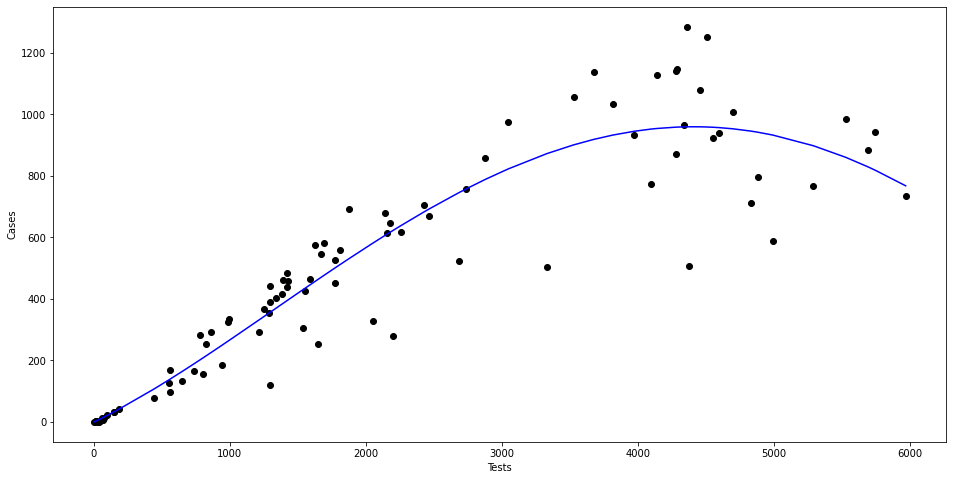

In [ ]:
### START CODE HERE ###
# Instantiate a 4th-degree polynomial features object
poly = PolynomialFeatures(degree=4)
# Use that object to generate a transformed X array with higher-degree feature columns
X_poly = poly.fit_transform(X)
# Instantiate a linear regression model
lin2 = LinearRegression() 
# Train the model on the TRANSFORMED feature array and the target array
lin2.fit(X_poly, y) 
# Use your newly trained model to compute predicted target values based on the feature values
pred = lin2.predict(X_poly)
### END CODE HERE ###
# Visualize your (highly reduced) ground truth data and model
new_X, new_y = zip(*sorted(zip(X, pred)))
plt.figure(figsize=(16, 8))
plt.scatter(
    X,
    y,
    c='black'
)
plt.plot(
    new_X, new_y,
    c='blue'
)
plt.xlabel("Tests")
plt.ylabel("Cases")
plt.show()


### Compute the MSE for both your linear and polynomial regression models

Which performed better?

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
print("Linear regression error is=", mean_squared_error(y, predictions, squared=False))
print("Polynomial regression error is=", mean_squared_error(y, pred, squared=False))

Linear regression error is= 171.79768160540917
Polynomial regression error is= 131.076775703435


In [ ]:
# R2 Squared:
print("Linear regression R2 is=", r2_score(y, predictions))
print("Polynomial regression R2 is=", r2_score(y, pred))

Linear regression R2 is= 0.7768795459594345
Polynomial regression R2 is= 0.8701158109409867


In [ ]:
#Adjusted R2 Squared
print("Linear regression Adjusted R2 is=", 1-(1-r2_score(y, predictions))*(X.shape[0]-1)/(X.shape[0]-(X.shape[1]-1)-1))
print("Polynomial regression Adjusted R2 is=", 1-(1-r2_score(y, pred))*(X_poly.shape[0]-1)/(X_poly.shape[0]-(X_poly.shape[1]-1)-1))

Linear regression Adjusted R2 is= 0.7768795459594345
Polynomial regression Adjusted R2 is= 0.8639308495572241


The Polynomial Regression worked better as suggested by RMSE, R2 & Adjusted R2 Metrics